In [8]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertModel.from_pretrained("bert-base-cased")

def get_embeddings(text):
    # Tokenize and convert to input IDs
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # Get embeddings; only use the last hidden state here
    with torch.no_grad():
        outputs = model(**inputs)
    # Return the mean of the embeddings across the token dimension
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Load data
def load_data_and_extract_embeddings(file_path):
    df = pd.read_csv(file_path)
    # Extract embeddings
    df['Embeddings'] = df['INSTANCE_COLUMN'].apply(get_embeddings)
    return df

df_modified = load_data_and_extract_embeddings("modified_goldstandard.csv")
df_flant5_large = load_data_and_extract_embeddings("flant5_large_augmented_data.csv")
df_flant5_xxl = load_data_and_extract_embeddings("flant5_xxl_augmented_data.csv")
df_gpt4 = load_data_and_extract_embeddings("gpt4_augmented_data.csv")

In [5]:
def get_average_embeddings(df):
    # Group by 'CUE_COLUMN' and 'LABEL_COLUMN' and calculate the mean of embeddings
    return df.groupby(['#CUE_COLUMN', 'LABEL_COLUMN'])['Embeddings'].apply(lambda x: np.mean(np.vstack(x), axis=0)).reset_index()

# Calculate average embeddings for each dataset
avg_emb_modified = get_average_embeddings(df_modified)
avg_emb_flant5_large = get_average_embeddings(df_flant5_large)
avg_emb_flant5_xxl = get_average_embeddings(df_flant5_xxl)
avg_emb_gpt4 = get_average_embeddings(df_gpt4)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 688 samples in 0.000s...
[t-SNE] Computed neighbors for 688 samples in 0.247s...
[t-SNE] Computed conditional probabilities for sample 688 / 688
[t-SNE] Mean sigma: 1.064221
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.891121
[t-SNE] KL divergence after 1000 iterations: 1.253462


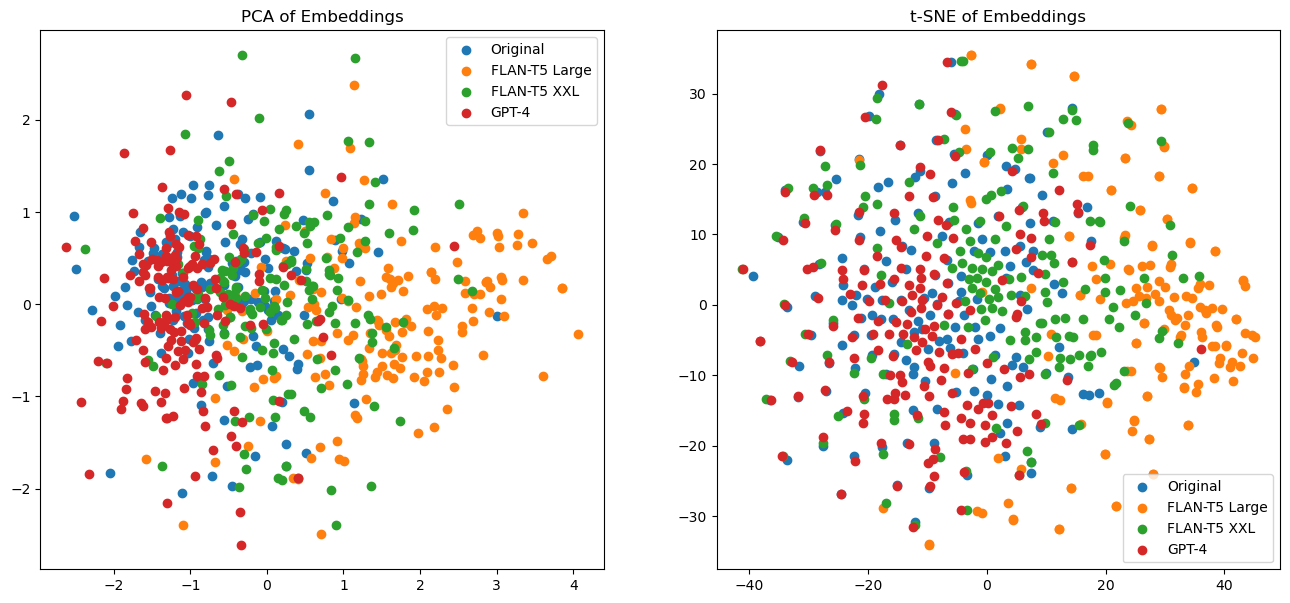

In [6]:
def plot_embeddings(data_list, labels):
    all_embeddings = np.vstack([d['Embeddings'].tolist() for d in data_list])
    all_labels = sum([[label] * len(d) for label, d in zip(labels, data_list)], [])
    
    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(all_embeddings)
    
    # t-SNE
    tsne = TSNE(n_components=2, verbose=1)
    tsne_results = tsne.fit_transform(all_embeddings)
    
    # Plotting
    plt.figure(figsize=(16, 7))
    for i, label in enumerate(labels):
        indices = [idx for idx, val in enumerate(all_labels) if val == label]
        plt.subplot(1, 2, 1)
        plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=label)
        plt.title('PCA of Embeddings')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=label)
        plt.title('t-SNE of Embeddings')
        plt.legend()

    plt.show()

# Combine data and labels
data_list = [avg_emb_modified, avg_emb_flant5_large, avg_emb_flant5_xxl, avg_emb_gpt4]
labels = ['Original', 'FLAN-T5 Large', 'FLAN-T5 XXL', 'GPT-4']

# Plot embeddings
plot_embeddings(data_list, labels)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 688 samples in 0.000s...
[t-SNE] Computed neighbors for 688 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 688 / 688
[t-SNE] Mean sigma: 1.064221
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.432884
[t-SNE] KL divergence after 1000 iterations: 1.308875


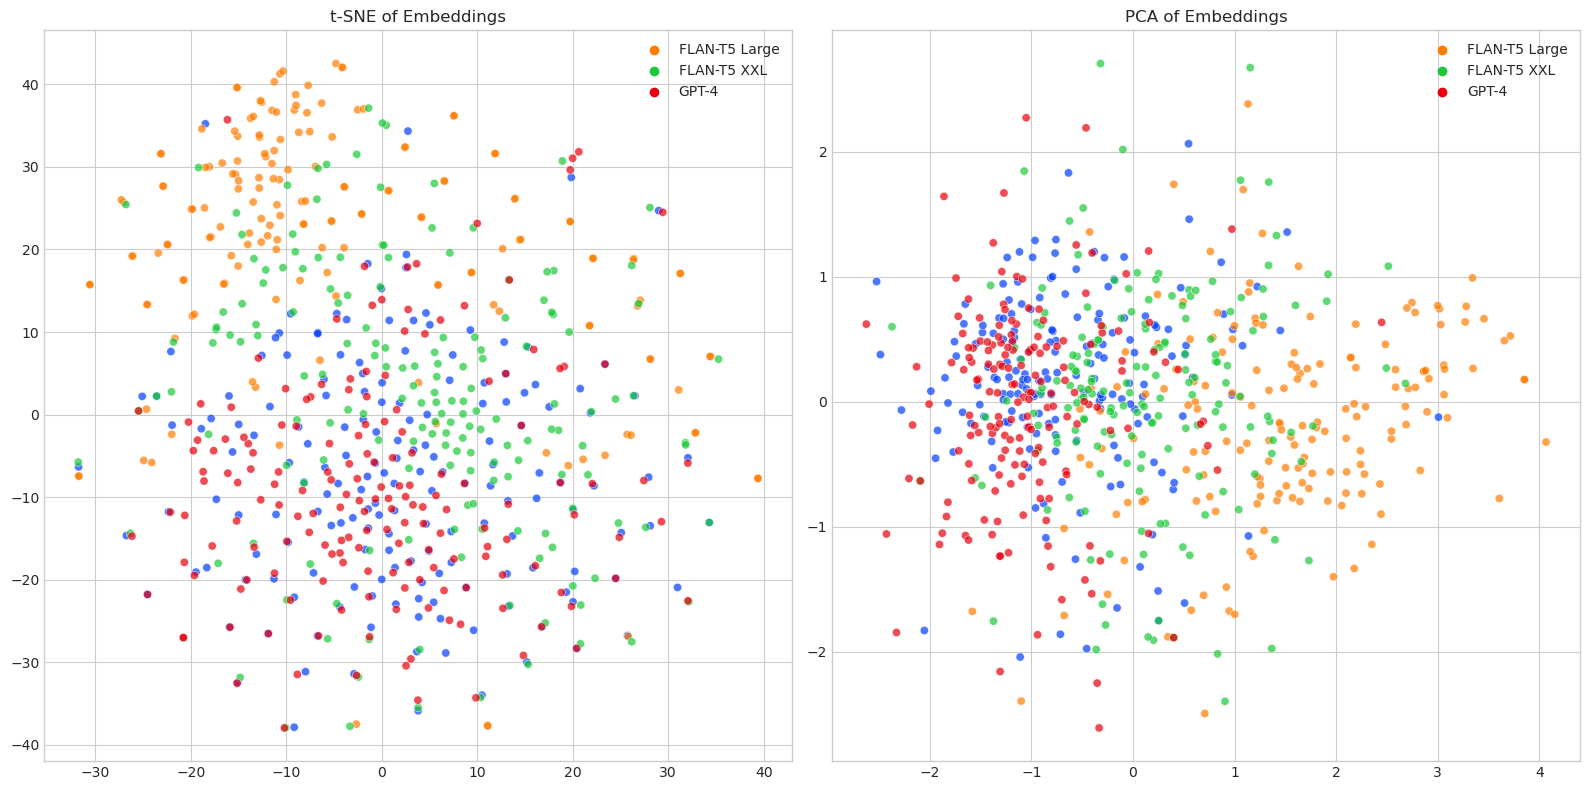

In [13]:
# Styling for plots similar to seaborn's style
plt.style.use('seaborn-whitegrid')

all_embeddings = np.vstack([d['Embeddings'].tolist() for d in data_list])
all_labels = sum([[label] * len(d) for label, d in zip(labels, data_list)], [])

# PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(all_embeddings)

# t-SNE
tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(all_embeddings)

# Define your color palette here
palette = sns.color_palette("bright", len(np.unique(all_labels)))

# Create the figure and the axes
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# TSNE plot
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=all_labels, 
                palette=palette, alpha=0.7, ax=ax[0])
ax[0].set_title('t-SNE of Embeddings')

# PCA plot
sns.scatterplot(x=pca_results[:, 0], y=pca_results[:, 1], hue=all_labels, 
                palette=palette, alpha=0.7, ax=ax[1])
ax[1].set_title('PCA of Embeddings')
unique_labels = np.unique(all_labels)
# Remove the legend title (which is 'hue' by default)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles=handles[1:], labels=labels[1:])
ax[1].legend(handles=handles[1:], labels=labels[1:])

# Show the plot
plt.tight_layout()
plt.show()